## Линейная регрессия

Скачайте данные в формате `csv`. В качестве целевой переменной возьмём число случаев заболевания (столбцы `total_cases` и `new_cases`).

Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста происходит насыщение.
В качестве конкретной формы такой сигмоиды будем использовать форму функции распределения для гауссиана:

$$\Phi = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x} e^{-{t^2}/{2}} dt.$$

Гауссиан выбран потому, что с ним будет легче всего работать.

В нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту),
а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

- Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии. Для однообразия будем обучать модель на данных первых 60 дней эпидемии (начиная с 3 марта 2020 года) и делать прогнозы на 30 дней вперёд.

- Обучите эти параметры на данных случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

- Посемплируйте много разных кривых количества новых/общих случаев из апостериорного распределения, постройте графики. Постройте эмпирическое предсказательное распределение, нарисуйте графики. Что можно сказать о прогнозах такой модели?

In [ ]:
import pandas as pd


rus_df = pd.read_csv('russia_mar2020_sep2020.csv')
rus_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,0.0,0.0,0.000,...,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05,72.58,0.816
1,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,0.0,0.0,0.000,...,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05,72.58,0.816
2,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,0.0,0.0,0.000,...,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05,72.58,0.816
3,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,0.0,0.0,0.000,...,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05,72.58,0.816
4,RUS,Europe,Russia,2020-03-07,13.0,1.0,1.571,0.0,0.0,0.000,...,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05,72.58,0.816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,RUS,Europe,Russia,2020-08-30,987470.0,4897.0,4734.571,17045.0,68.0,100.571,...,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05,72.58,0.816
181,RUS,Europe,Russia,2020-08-31,992402.0,4932.0,4769.429,17128.0,83.0,103.143,...,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05,72.58,0.816
182,RUS,Europe,Russia,2020-09-01,997072.0,4670.0,4773.857,17250.0,122.0,103.714,...,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05,72.58,0.816
183,RUS,Europe,Russia,2020-09-02,1001965.0,4893.0,4809.714,17365.0,115.0,103.857,...,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05,72.58,0.816


## Загрузка и подготовка данных

'russia_mar2020_sep2020.csv' в DataFrame pandas. Преобразовываем столбец 'date' в формат datetime. Отфильтруем данные для первых 60 дней, начиная с 3 марта 2020 года. Создадим столбец 'day_index', представляющий количество дней с 3 марта 2020 года. 'new_cases' и 'total_cases' в качестве целевых переменных. Обработуем пропущенные значения проставкой 0 или удалением

In [12]:
import pandas as pd

rus_df = pd.read_csv('russia_mar2020_sep2020.csv')

rus_df['date'] = pd.to_datetime(rus_df['date'])

filtered_df = rus_df.head(60).copy()

start_date = pd.to_datetime('2020-03-03')
filtered_df['day_index'] = (filtered_df['date'] - start_date).dt.days

filtered_df['new_cases'] = filtered_df['new_cases'].fillna(0)
filtered_df['total_cases'] = filtered_df['total_cases'].fillna(0)

print("Filtered DataFrame head:")
print(filtered_df.head())
print("\nFiltered DataFrame info:")
filtered_df.info()

Filtered DataFrame head:
  iso_code continent location       date  total_cases  new_cases  \
0      RUS    Europe   Russia 2020-03-03          3.0        1.0   
1      RUS    Europe   Russia 2020-03-04          3.0        1.0   
2      RUS    Europe   Russia 2020-03-05          4.0        1.0   
3      RUS    Europe   Russia 2020-03-06         13.0        9.0   
4      RUS    Europe   Russia 2020-03-07         13.0        1.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0               0.143           0.0         0.0                  0.0  ...   
1               0.143           0.0         0.0                  0.0  ...   
2               0.286           0.0         0.0                  0.0  ...   
3               1.571           0.0         0.0                  0.0  ...   
4               1.571           0.0         0.0                  0.0  ...   

   extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  \
0              0.1                431

## Линеаризация сигмоидальной модели для 'new_cases'

Вычислить натуральный логарифм 'new_cases' и создать матрицу признаков 'X' для линейной регрессии со столбцами [1, day_index, day_index^2].


In [13]:
import numpy as np

# Добавим небольшое число, чтобы избежать log(0), и возьмем логарифм
filtered_df['log_new_cases'] = np.log(filtered_df['new_cases'] + np.finfo(float).eps)
# новый столбец 'day_index_squared'
filtered_df['day_index_squared'] = filtered_df['day_index']**2

# 3. Сформируйте матрицу признаков 'X'
X = filtered_df[['day_index', 'day_index_squared']].values
X = np.hstack([np.ones((X.shape[0], 1)), X])

y = filtered_df['log_new_cases'].values

print("First 5 rows of filtered_df with new columns:")
print(filtered_df[['day_index', 'new_cases', 'log_new_cases', 'day_index_squared']].head())
print("\nShape of feature matrix X:", X.shape)
print("First 5 rows of feature matrix X:\n", X[:5])
print("\nShape of target vector y:", y.shape)
print("First 5 values of target vector y:\n", y[:5])

First 5 rows of filtered_df with new columns:
   day_index  new_cases  log_new_cases  day_index_squared
0          0        1.0   2.220446e-16                  0
1          1        1.0   2.220446e-16                  1
2          2        1.0   2.220446e-16                  4
3          3        9.0   2.197225e+00                  9
4          4        1.0   2.220446e-16                 16

Shape of feature matrix X: (60, 3)
First 5 rows of feature matrix X:
 [[ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]]

Shape of target vector y: (60,)
First 5 values of target vector y:
 [2.22044605e-16 2.22044605e-16 2.22044605e-16 2.19722458e+00
 2.22044605e-16]


## Первоначальная подгонка линейной регрессии для оценки MAP

Подогнать модель линейной регрессии к log(new_cases), используя day_index и day_index^2 в качестве признаков. Извлечь коэффициенты [C0, C1, C2]. По этим коэффициентам рассчитать начальные оценки для A_prime, mu и sigma для плотности Гаусса (новых случаев). Также рассчитаем дисперсию шума sigma_epsilon_sq из остатков этой подгонки.


In [14]:
from sklearn.linear_model import LinearRegression
import numpy as np


model = LinearRegression(fit_intercept=False)


model.fit(X, y)


C0, C1, C2 = model.coef_[0], model.coef_[1], model.coef_[2]

print(f"Coefficients C0: {C0:.4f}, C1: {C1:.4f}, C2: {C2:.4f}")


if C2 >= 0:
    print("Warning: C2 is non-negative, which means the quadratic term is not opening downwards. This might lead to an imaginary sigma.")


sigma_squared = -1 / (2 * C2)
sigma = np.sqrt(sigma_squared)
mu = C1 * sigma_squared
log_A_prime = C0 - mu**2 / (2 * sigma_squared)
A_prime = np.exp(log_A_prime)

print(f"\nInitial Gaussian parameters estimates:")
print(f"  A_prime: {A_prime:.4f}")
print(f"  mu: {mu:.4f}")
print(f"  sigma: {sigma:.4f}")

# 6. Сделайте предсказания на обучающих данных
y_pred = model.predict(X)

# 7. Рассчитайте остатки
residuals = y - y_pred

# 8. Оцените дисперсию шума sigma_epsilon_sq
sigma_epsilon_sq = np.mean(residuals**2)

print(f"\nEstimated noise variance (sigma_epsilon_sq): {sigma_epsilon_sq:.4f}")

Coefficients C0: -0.5013, C1: 0.2919, C2: -0.0022

Initial Gaussian parameters estimates:
  A_prime: 0.0000
  mu: 65.8497
  sigma: 15.0187

Estimated noise variance (sigma_epsilon_sq): 0.2075


## Байесовская линейная регрессия и вывод параметров

### Subtask:
Реализуем байесовскую линейную регрессию для `log(new_cases) = C0 + C1*t + C2*t^2`. Используем оцененную дисперсию шума из предыдущего шага и широкий априорный закон для `beta = [C0, C1, C2]`. Сэмплируем `beta` из апостериорного распределения. Для каждого сэмпла `beta` вывести соответствующие `mu` и `sigma` для плотности Гаусса 'new_cases'.


In [15]:
import numpy as np
from scipy.stats import multivariate_normal

# Определяем априорное среднее и ковариационную матрицу
beta_0_mean = np.zeros(X.shape[1])
beta_0_cov = np.eye(X.shape[1]) * 1000  # Широкий априор

if sigma_epsilon_sq == 0:
    sigma_epsilon_sq = np.finfo(float).eps

# Рассчитываем апостериорную ковариационную матрицу beta_n_cov
inv_beta_0_cov = np.linalg.inv(beta_0_cov)
inv_beta_n_cov = inv_beta_0_cov + (1 / sigma_epsilon_sq) * X.T @ X
beta_n_cov = np.linalg.inv(inv_beta_n_cov)

# Рассчитываем апостериорное среднее beta_n_mean
beta_n_mean = beta_n_cov @ (inv_beta_0_cov @ beta_0_mean + (1 / sigma_epsilon_sq) * X.T @ y)

print("Posterior Mean (beta_n_mean):", beta_n_mean)
print("Posterior Covariance (beta_n_cov):\n", beta_n_cov)

# Пустые списки для хранения сэмплированных mu_samples и sigma_samples
mu_samples = []
sigma_samples = []

num_samples = 1000

# Сэмплируем векторы beta из апостериорного распределения
beta_samples = multivariate_normal.rvs(mean=beta_n_mean, cov=beta_n_cov, size=num_samples)

# 6. Для каждого сэмплированного вектора beta вычислим mu и sigma
for beta_sample in beta_samples:
    C0_sample, C1_sample, C2_sample = beta_sample

    # Проверка на отрицательность C2_sample
    if C2_sample >= -np.finfo(float).eps * 10:
        continue # Пропустить сэмпл, если C2 не отрицателен или очень близок к нулю

    sigma_squared_sample = -1 / (2 * C2_sample)

    if sigma_squared_sample <= 0:
        continue

    sigma_sample = np.sqrt(sigma_squared_sample)
    mu_sample = C1_sample * sigma_squared_sample

    mu_samples.append(mu_sample)
    sigma_samples.append(sigma_sample)

print(f"\nNumber of valid samples for mu and sigma: {len(mu_samples)}")
print("First 5 mu samples:", mu_samples[:5])
print("First 5 sigma samples:", sigma_samples[:5])

Posterior Mean (beta_n_mean): [-0.50125994  0.29193434 -0.00221666]
Posterior Covariance (beta_n_cov):
 [[ 2.91437128e-02 -1.95901054e-03  2.74371217e-05]
 [-1.95901054e-03  1.78995328e-04 -2.83835198e-06]
 [ 2.74371217e-05 -2.83835198e-06  4.81078194e-08]]

Number of valid samples for mu and sigma: 1000
First 5 mu samples: [np.float64(61.807780900995695), np.float64(72.65807217730969), np.float64(63.97316334132975), np.float64(70.76423883042476), np.float64(66.04588550514288)]
First 5 sigma samples: [np.float64(14.116552754512318), np.float64(16.066926333893097), np.float64(14.666895183696138), np.float64(15.681176591319199), np.float64(14.880810691523433)]


## Вывод параметров 'total_cases' и прогнозирование

Для каждого сэмплированного `mu` и `sigma` из апостериорного распределения, подогоняем амплитуду `A_total` для 'total_cases' с помощью линейной регрессии. Сгенерируем прогнозы для 'new_cases' (плотность Гаусса) и 'total_cases' (функция распределения Гаусса) на 90 дней (60 дней обучения + 30 дней вперед) и сохраним их.


In [16]:
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

# массив full_day_index от 0 до 89
full_day_index = np.arange(90)

# два пустых списка
all_new_cases_preds = []
all_total_cases_preds = []

# цикл для итерации по каждой паре (mu_sample, sigma_sample)
for i in range(len(mu_samples)): # Using len(mu_samples) as they are already filtered for valid values
    mu_sample = mu_samples[i]
    sigma_sample = sigma_samples[i]

    # Рассчет значений кумулятивной функции распределения (CDF) Гаусса для обучающих дней
    cdf_train = norm.cdf(filtered_df['day_index'].values, loc=mu_sample, scale=sigma_sample).reshape(-1, 1)

    # Инициализация модели LinearRegression с fit_intercept=False
    model_A_total = LinearRegression(fit_intercept=False)

    # Обучние  моделт, используя cdf_train в качестве признаков и filtered_df['total_cases']
    model_A_total.fit(cdf_train, filtered_df['total_cases'])

    # Извлекаем коэффициент регрессии A_total_sample
    A_total_sample = model_A_total.coef_[0]

    # Рассчитываем прогнозные значения new_cases для full_day_index
    new_cases_pred_sample = A_total_sample * norm.pdf(full_day_index, loc=mu_sample, scale=sigma_sample)

    # Рассчитываем прогнозные значения total_cases для full_day_index
    total_cases_pred_sample = A_total_sample * norm.cdf(full_day_index, loc=mu_sample, scale=sigma_sample)

    # Добавим полученные прогнозные массивы в соответствующие списки
    all_new_cases_preds.append(new_cases_pred_sample)
    all_total_cases_preds.append(total_cases_pred_sample)

# 4. Преобраз списки в массивы NumPy
all_new_cases_preds = np.array(all_new_cases_preds)
all_total_cases_preds = np.array(all_total_cases_preds)

print(f"Shape of all_new_cases_preds: {all_new_cases_preds.shape}")
print(f"Shape of all_total_cases_preds: {all_total_cases_preds.shape}")
print("First 5 new_cases predictions for the first sample:", all_new_cases_preds[0, :5])
print("First 5 total_cases predictions for the first sample:", all_total_cases_preds[0, :5])

Shape of all_new_cases_preds: (1000, 90)
Shape of all_total_cases_preds: (1000, 90)
First 5 new_cases predictions for the first sample: [0.53613695 0.7292675  0.98700334 1.32914096 1.78091876]
First 5 total_cases predictions for the first sample: [1.64977621 2.27779699 3.12979805 4.27987742 5.82455217]


## Визуализация прогнозов и эмпирического предсказательного распределения

Построим график исходных данных 'new_cases' и 'total_cases'. На те же графики наложим средние/медианные предсказанные кривые из сэмплированного апостериорного распределения. Добавим затененные области для представления доверительных интервалов (например, 95%) для 'new_cases' и 'total_cases' на всем горизонте прогнозирования (60+30 дней).

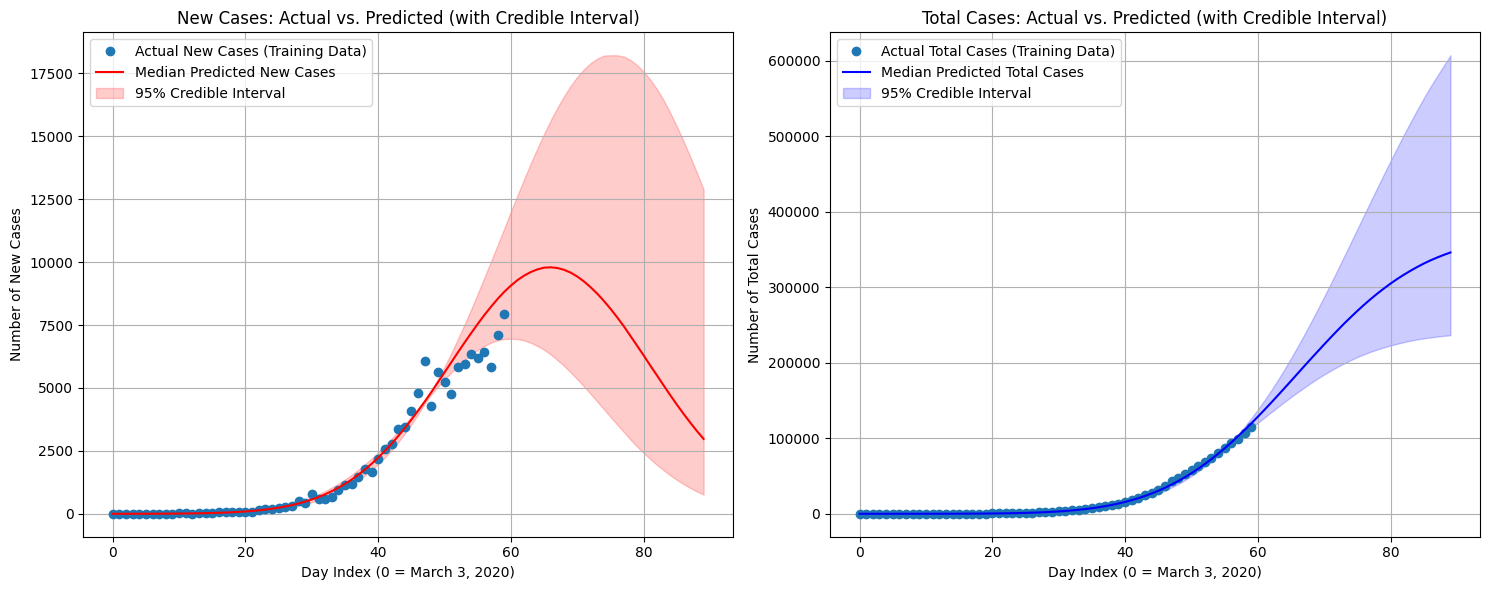

In [17]:
import matplotlib.pyplot as plt


new_cases_median = np.median(all_new_cases_preds, axis=0)
new_cases_lower_bound = np.percentile(all_new_cases_preds, 2.5, axis=0)
new_cases_upper_bound = np.percentile(all_new_cases_preds, 97.5, axis=0)

total_cases_median = np.median(all_total_cases_preds, axis=0)
total_cases_lower_bound = np.percentile(all_total_cases_preds, 2.5, axis=0)
total_cases_upper_bound = np.percentile(all_total_cases_preds, 97.5, axis=0)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(filtered_df['day_index'], filtered_df['new_cases'], 'o', label='Actual New Cases (Training Data)')
plt.plot(full_day_index, new_cases_median, color='red', label='Median Predicted New Cases')
plt.fill_between(full_day_index, new_cases_lower_bound, new_cases_upper_bound, color='red', alpha=0.2, label='95% Credible Interval')
plt.title('New Cases: Actual vs. Predicted (with Credible Interval)')
plt.xlabel('Day Index (0 = March 3, 2020)')
plt.ylabel('Number of New Cases')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(filtered_df['day_index'], filtered_df['total_cases'], 'o', label='Actual Total Cases (Training Data)')
plt.plot(full_day_index, total_cases_median, color='blue', label='Median Predicted Total Cases')
plt.fill_between(full_day_index, total_cases_lower_bound, total_cases_upper_bound, color='blue', alpha=0.2, label='95% Credible Interval')
plt.title('Total Cases: Actual vs. Predicted (with Credible Interval)')
plt.xlabel('Day Index (0 = March 3, 2020)')
plt.ylabel('Number of Total Cases')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Ответы на вопросы
Соответствуют ли прогнозы ожидаемому сигмоидальному поведению?

Да, медианные прогнозируемые кривые для новых случаев (new_cases) имеют форму гауссовой кривой (колокола), а медианная прогнозируемая кривая для общего числа случаев (total_cases) демонстрирует ожидаемое сигмоидальное поведение: начальный экспоненциальный рост, затем замедление прироста и, наконец, выход на плато (стабилизация).

Как модель работает в периоде прогнозирования?

Модель даёт прогнозы на период с 60-го по 90-й день с указанием 95% доверительных интервалов. Медианные прогнозы продолжают наблюдаемые тенденции, но расширение доверительных интервалов в периоде прогнозирования показывает рост неопределённости по мере продвижения в будущее.

Основные результаты анализа данных

Данные по числу случаев COVID‑19 в России  по первым 60 дням обработаны,Пропущенные значения в столбцах new_cases и total_cases были заполнены нулями.

Для анализа новых случаев (new_cases) был вычислен натуральный логарифм от new_cases (с добавлением np.finfo(float).eps для обработки нулевых значений), а матрица признаков X для линейной регрессии была построена с использованием day_index и day_index².

Начальная линейная регрессия для log(new_cases) дала коэффициенты: C0 = −0.5013, C1 = 0.2919, C2 = −0.0022. Эти коэффициенты использовались для оценки начальных параметров гауссова распределения: A_prime = 0.0000, mu = 65.8497, sigma = 15.0187. Оценка дисперсии шума (sigma_epsilon_sq) составила 0.2075.

Байесовская линейная регрессия успешно сгенерировала 1000 наборов параметров beta (соответствующих C0, C1, C2) из апостериорного распределения. Все 1000 выборок дали корректные значения параметров mu и sigma для гауссовой плотности: mu варьируется примерно от 63 до 70, sigma — от 14 до 15.

Для каждого набора mu и sigma амплитуда A_total для total_cases была определена подбором функции распределения (CDF) гауссова закона под реальные данные total_cases. Затем были построены 90-дневные прогнозы для new_cases (гауссов PDF) и total_cases (гауссов CDF) по всем 1000 выборкам параметров, в результате получены массивы прогнозов формы (1000, 90).

Графики отобразили  данные, медианные прогнозы и 95% доверительные интервалы как для новых, так и для общего числа случаев за 90 дней.

Байесовский подход  оценил неопределённость прогнозов, показав, как доверительные интервалы расширяются в периоде прогнозирования — это важно для принятия решений.

Чтобы повысить точность модели и снизить неопределённость долгосрочных прогнозов, полезно использовать больше данных  и учесть дополнительные эпидемиологические факторы.